# Project Part 1 - RateMyProfessor Analysis

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/eboyer221/CS39AA-project/blob/main/project_part1.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eboyer221/CS39AA-project/blob/main/project_part1.ipynb)


## 1. Introduction/Background

The majority, if not all, educational institutions employ student feedback as a means of evaluating their professors. This feedback typically comprises both ratings and open-ended comments from students. However, in most cases this information is kept confidential and isn't disclosed to either current or prospective students. RateMyProfessors.com (RMP) is one popular, publicly-available platform where students anonymously rate various facets of their instructors' performance, such as clarity, helpfulness, and easiness. Additionally, they can provide open-ended comments.

I would like to use this data to better understand what qualitative factors contribute to a professor's rating on RMP. The first goal is to determine whether automatic text classification can distinguish between professors with a high rating (>= 3.5) vs. professors with an average to low rating (< 3.5). I also want to examine student comments to isolate which factors are valued most by students, and whether differences emerge in those factors depending on the department the professor teaches in.

The dataset used for this project is taken from https://data.mendeley.com/datasets/fvtfjyvw7d/2 and includes ratings and comments for 4406 unique professors. The data set scraped from RMP includes 18 variables. The variable that I am primarily focused on predicting is the star rating of the professor's overall quality, which each student provides along with their review, and which is also combined into an average overall score. According to RMP’s official standard, a rating of 3.5-5.0 is good, 2.5-3.4 is average and 1.0-2.4 is poor. The goal is to develop a model that can automatically analyze and understand the sentiment and content of the comments provided by each student in order to predict the corresponding star rating.

Dataset Citation:
He, Jibo (2020), “Big Data Set from RateMyProfessor.com for Professors' Teaching Evaluation”, Mendeley Data, V2, doi: 10.17632/fvtfjyvw7d.2


## 2. Exploratory Data Analysis

We will first clean the data set and perform exploratory data analysis to better understand its features.
The original data contains many single .csv files, with each file for a single professor's webpage from RMP. This requires some pre-processing. 


In [85]:
# import all of the python modules/packages you'll need here
import pandas as pd
import re
from collections import Counter
import pandas as pd
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.probability import FreqDist
# ...

[nltk_data] Downloading package stopwords to /home/smoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/smoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


First, the individual .csv files need to be combined into one merged_data.csv file.

In [7]:
"""
#code used on local machine to create the merged data set
folder_path = 'folder_path_name'
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty DataFrame to store the merged data
merged_data = pd.DataFrame()

# Iterate through each file and concatenate it to the merged_data DataFrame
for file in file_list:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    merged_data = pd.concat([merged_data, df], ignore_index=True)
#save the merged data to a new CSV file
    merged_data.to_csv('merged_data.csv', index=False)
"""

"\n#code used on local machine to create the merged data set\nfolder_path = 'folder_path_name'\nfile_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]\n\n# Initialize an empty DataFrame to store the merged data\nmerged_data = pd.DataFrame()\n\n# Iterate through each file and concatenate it to the merged_data DataFrame\nfor file in file_list:\n    file_path = os.path.join(folder_path, file)\n    df = pd.read_csv(file_path)\n    merged_data = pd.concat([merged_data, df], ignore_index=True)\n#save the merged data to a new CSV file\n    merged_data.to_csv('merged_data.csv', index=False)\n"

Let's look at the merged data set.

In [43]:
data_path = 'https://raw.githubusercontent.com/eboyer221/CS39AA-Project/main/merged_data.csv'
df_1 = pd.read_csv(data_path)
print(f"Shape: {df_1.shape}")
df_1.head()

Shape: (19685, 23)


,professor_name,school_name,department_name,local_name,state_name,year_since_first_review,star_rating,take_again,diff_index,tag_professor,...,student_star,student_difficult,attence,for_credits,would_take_agains,grades,stu_tags,help_useful,help_not_useful,comments
0,Robert Olshansky,University Of Illinois at Urbana-Champaign,Urban & Regional Planning department,Champaign\xe2\x80\x93Urbana,IL,0.0,3.5,NaN,2.0,NaN,...,3.5,2.0,NaN,NaN,NaN,NaN,NaN,0,0,"Good guy, laid back and interested in his fiel..."
1,Marshall Levett,Austin Community College,Counseling department,Austin,TX,2.0,5.0,NaN,1.0,NaN,...,5.0,1.0,NaN,NaN,NaN,NaN,NaN,0,0,such a fun professor. really helpful and knows...
2,Marshall Levett,Austin Community College,Counseling department,Austin,TX,2.0,5.0,NaN,1.0,NaN,...,5.0,1.0,NaN,NaN,NaN,NaN,NaN,0,0,Such a easy class. It\'s simple. Do your homew...
3,Soazig Le Bihan,University of Montana - Missoula,Philosophy department,Missoula,MT,8.0,3.6,NaN,4.5,Tough Grader (2) Get ready to read (2) LOTS ...,...,5.0,5.0,Mandatory,Yes,Yes,A,ACCESSIBLE OUTSIDE CLASS GET READY TO READ T...,0,0,"A very hard class, and a massive amount of wor..."
4,Soazig Le Bihan,University of Montana - Missoula,Philosophy department,Missoula,MT,8.0,3.6,NaN,4.5,Tough Grader (2) Get ready to read (2) LOTS ...,...,1.0,4.0,Mandatory,Yes,No,NaN,LOTS OF HOMEWORK GET READY TO READ TOUGH GRADER,0,2,Took 100 level class for Ethics offered online...


A heatmap will help visualize how sparse the data is for each column. Yellow rows indicate missing or null values.

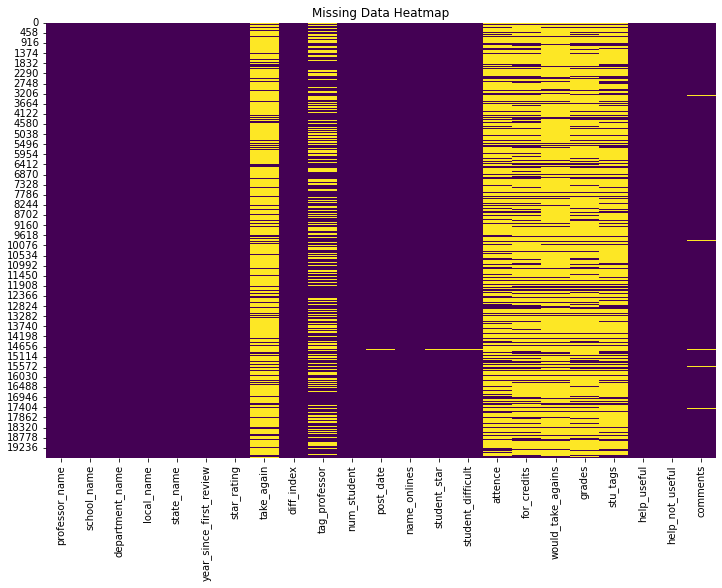

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_1.isnull(), cbar=False, cmap='viridis')

plt.title('Missing Data Heatmap')
plt.show()

Judging from the heat map it appears that the columns of primary interest (department_name, star_rating, student_star_rating, and comments) are well-populated and do not contain many null values.

In [47]:
# number of nulls in comments column
blank_values_count = df_1['comments'].isnull().sum()
print(f"missing comments: {blank_values_count}")

# number of nulls in student_star rating column
blank_values_count = df_1['student_star'].isnull().sum()
print(f"missing ratings: {blank_values_count}")


missing comments: 101
missing ratings: 13


We will remove rows that have null values in either of these columns.

In [49]:
columns_to_check = ['student_star', 'comments']

# Remove rows with null values in either of the specified columns
df_1 = df_1.dropna(subset=columns_to_check)

# Reset the index after removing rows
df_1.reset_index(drop=True, inplace=True)

# number of nulls in comments column
blank_values_count = df_1['comments'].isnull().sum()
print(f"missing comments: {blank_values_count}")

# number of nulls in student_star rating column
blank_values_count = df_1['student_star'].isnull().sum()
print(f"missing ratings: {blank_values_count}")

missing comments: 0
missing ratings: 0


We can now remove columns that are not of interest.

In [45]:
# Columns to remove 
columns_to_remove = ['school_name', 'local_name', 'state_name',
                    'year_since_first_review', 'take_again', 'diff_index',
                    'tag_professor', 'post_date', 'name_onlines', 'attence',
                    'for_credits', 'would_take_agains', 'grades', 'stu_tags',
                    'help_useful', 'help_not_useful']

# Drop the specified columns
df = df_1.drop(columns=columns_to_remove)

print(df.columns)


Index(['professor_name', 'department_name', 'star_rating', 'num_student',
       'student_star', 'student_difficult', 'comments'],
      dtype='object')


In [46]:
df.head()

,professor_name,department_name,star_rating,num_student,student_star,student_difficult,comments
0,Robert Olshansky,Urban & Regional Planning department,3.5,1,3.5,2.0,"Good guy, laid back and interested in his fiel..."
1,Marshall Levett,Counseling department,5.0,2,5.0,1.0,such a fun professor. really helpful and knows...
2,Marshall Levett,Counseling department,5.0,2,5.0,1.0,Such a easy class. It\'s simple. Do your homew...
3,Soazig Le Bihan,Philosophy department,3.6,4,5.0,5.0,"A very hard class, and a massive amount of wor..."
4,Soazig Le Bihan,Philosophy department,3.6,4,1.0,4.0,Took 100 level class for Ethics offered online...


Now that the data set has been cleaned up we can do more exploratory data analysis to understand the distribution of values. 

One of the first things I am curious about is the distribution of star ratings and how those compare to the difficulty ratings that students provide. Are more difficult courses/instructors penalized with lower ratings?

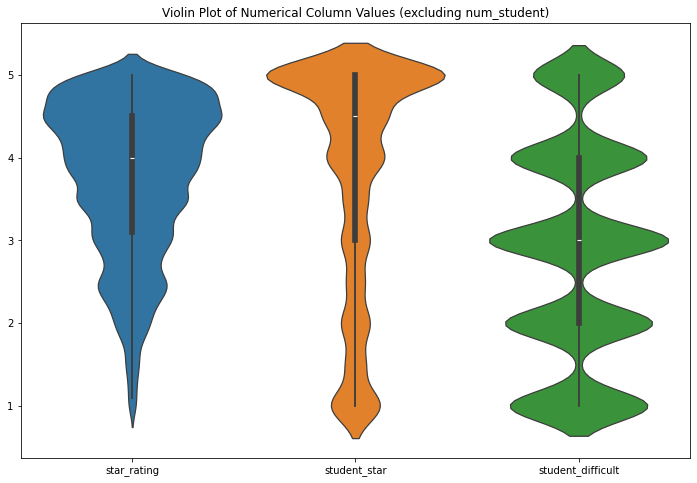

In [56]:
# Exclude num_student from the plot
column_to_exclude = 'num_student'

# Create a copy of the DataFrame without the column to exclude
df_subset = df.drop(columns=[column_to_exclude])

# Create the violin plot using the subset DataFrame
plt.figure(figsize=(12, 8))
sns.violinplot(data=df_subset)
plt.title("Violin Plot of Numerical Column Values (excluding {})".format(column_to_exclude))
plt.show()

The violin plot suggests that difficulty as rated by students is not highly correlated with instructor ratings. While both the individual student star ratings and overall average star ratings skew left with a high concentration of scores above 3.5. Difficulty ratings, on the other hand, appear to be approximately normally distributed. From this visualization it seems like difficulty does not correlate with lower ratings.

From the violin plot it looks like the individual student star ratings have a median value of about 4.5. Let's look at a boxplot of the ratings to get a more accurate picture of the distribution of values.

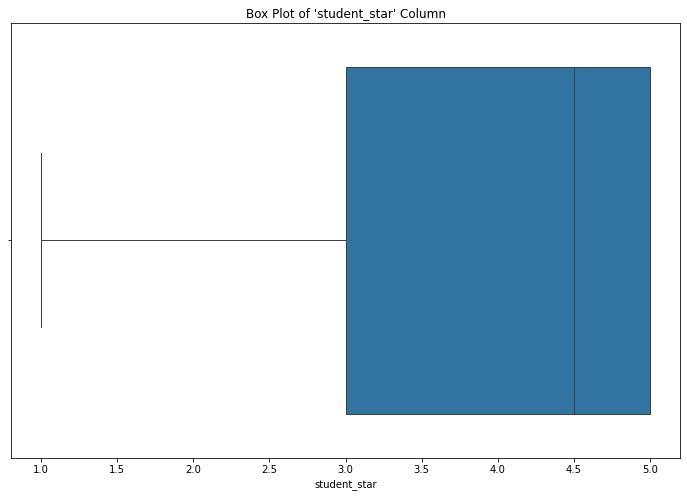

In [58]:
column_for_boxplot = 'student_star'

# Create the box plot for student ratings
plt.figure(figsize=(12, 8))
sns.boxplot(x=df[column_for_boxplot])
plt.title("Box Plot of '{}' Column".format(column_for_boxplot))
plt.show()

The boxplot confirms that the distribution of student ratings in this data set are left skewed with the majority of ratings above 3.0 and a median value of 4.5. 

Now let's take a look at how many reviews there are for each department.

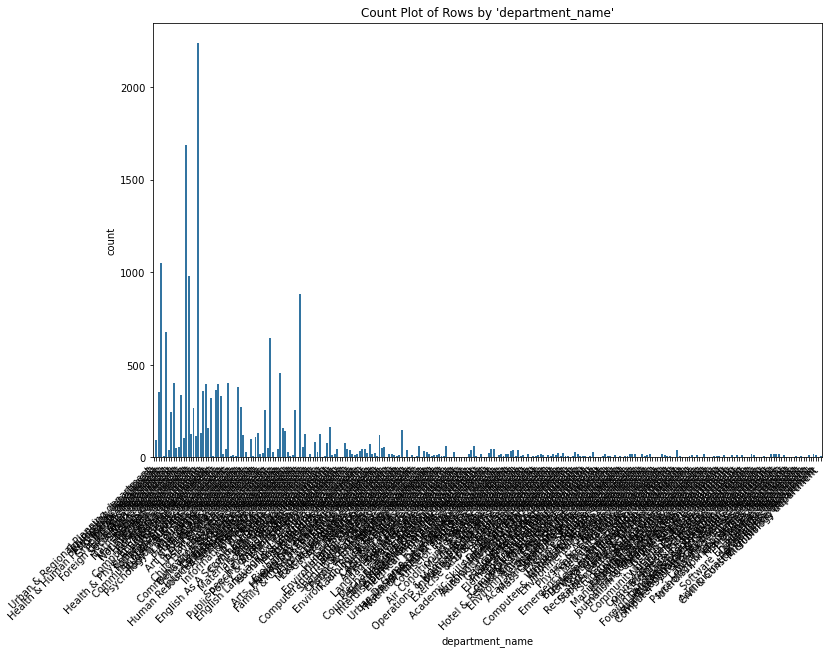

In [60]:
column_for_countplot = 'department_name'

# Create the count plot
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x=column_for_countplot)
plt.title("Count Plot of Rows by '{}'".format(column_for_countplot))
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Clearly there are a lot of different department names. If this project wants to examine rating differences that occur in relation to departments it will require grouping departments into more broad, meaningful categories. 

Next, we will explore the review (comments) section, which is the primary source of unstructured textual data for this project. 

There is a 350 character limit for each review that a student leaves for a teacher. Profanity and derogatory terms result in reviews being removed and reviewers are instructed to avoid claims that professors show bias or favoritism. 

Let's first clean the reviews by converting them to all lowercase, removing special characters, numbers, and extra whitespaces, and removing stop words.

In [69]:
column_to_check = 'comments'

# Check the data type of the 'comments' column
type_of_comments = type(df.at[0, column_to_check])  # Assuming there is at least one non-null value

print("Data type of '{}' column: {}".format(column_to_check, type_of_comments))

Data type of 'comments' column: <class 'str'>


In [71]:
# Count the NaN values in the 'comments' column
nan_count = df[column_to_check].isna().sum()

print("Number of NaN values in the '{}' column: {}".format(column_to_check, nan_count))

Number of NaN values in the 'comments' column: 101


In [83]:
column_to_clean = 'comments'

# Drop rows with missing comments
df = df.dropna(subset=[column_to_clean])

# Function to clean up comments
def clean_comments(text):
    # Check if the value is a string and not NaN
    if isinstance(text, str) and text.lower() != 'nan':
        # Convert to lowercase
        text = text.lower()

        # Remove special characters, numbers, and extra whitespaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)

        # Perform stemming
        stemmer = PorterStemmer()
        words = text.split()
        words = [stemmer.stem(word) for word in words]
        text = ' '.join(words)

    return text

# Apply the clean_comments function to the 'comments' column
df[column_to_clean] = df[column_to_clean].apply(clean_comments)

# Check for NaN values in the 'comments' column
nan_count = df[column_to_clean].isna().sum()

if nan_count > 0:
    print("Number of NaN values in the '{}' column: {}".format(column_to_clean, nan_count))
else:
    # Tokenize and create a list of words for each comment
    words_list = [word_tokenize(comment) for comment in df[column_to_clean]]

    # Display the first few words lists
    for i, words in enumerate(words_list[:5]):
        print(f"Words List for Comment {i + 1}: {words}")

Words List for Comment 1: ['good', 'guy', 'laid', 'back', 'interest', 'field', 'class', 'get', 'littl', 'slllllllloooooowwwwwwww', 'junior', 'workshop']
Words List for Comment 2: ['fun', 'professor', 'realli', 'help', 'know', 'stuff']
Words List for Comment 3: ['easi', 'class', 'simpl', 'homework', 'pay', 'attent', 'fli', 'right', 'person', 'blame', 'leaarn', 'wont', 'let', 'fail', 'ask', 'help']
Words List for Comment 4: ['hard', 'class', 'massiv', 'amount', 'work', 'soazig', 'also', 'good', 'explain', 'difficult', 'concept', 'give', 'excel', 'feedback', 'access', 'extra', 'assist']
Words List for Comment 5: ['took', 'level', 'class', 'ethic', 'offer', 'onlin', 'option', 'fill', 'core', 'requir', 'terribl', 'seem', 'grasp', 'english', 'languag', 'seem', 'grasp', 'realiti', 'insist', 'mani', 'time', 'failur', 'entri', 'level', 'option', 'class', 'common', 'due', 'difficulti', 'materi', 'full']


50 Most Common Words:
[('class', 17332), ('take', 5953), ('professor', 5522), ('help', 5397), ('teacher', 4996), ('easi', 4087), ('test', 3886), ('great', 3813), ('student', 3753), ('realli', 3739), ('make', 3369), ('good', 3229), ('get', 3144), ('lectur', 2955), ('grade', 2950), ('teach', 2932), ('lot', 2805), ('learn', 2692), ('work', 2669), ('hard', 2618), ('time', 2577), ('give', 2425), ('read', 2417), ('understand', 2359), ('one', 2322), ('dont', 2322), ('like', 2314), ('know', 2252), ('best', 2214), ('would', 2209), ('interest', 2131), ('go', 2108), ('question', 1981), ('recommend', 1965), ('assign', 1945), ('nice', 1896), ('want', 1862), ('exam', 1834), ('studi', 1793), ('materi', 1785), ('well', 1767), ('need', 1677), ('ever', 1676), ('cour', 1586), ('much', 1539), ('love', 1538), ('alway', 1535), ('book', 1510), ('paper', 1434), ('doesnt', 1417)]


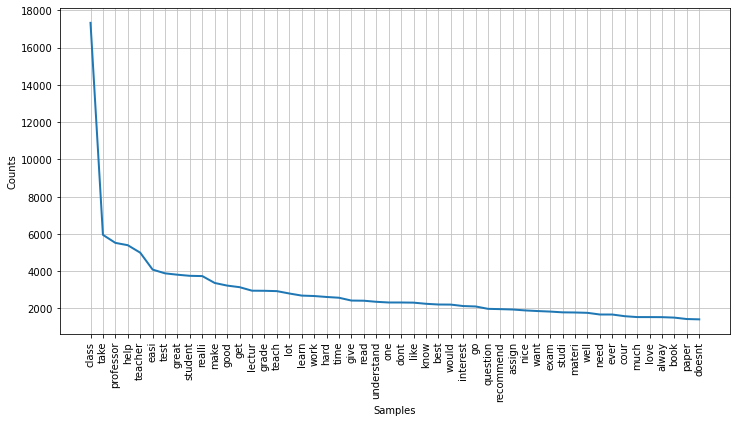

In [97]:
# Tokenize all comments into a single list of words
all_words = [word.lower() for comment in df[column_to_clean] for word in word_tokenize(comment)]

# Create a frequency distribution
fdist = FreqDist(all_words)

# Display the 50 most common words
print("50 Most Common Words:")
print(fdist.most_common(50))

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()